In [2]:
import catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\ivane\Desktop\Dissertation\data\merged_data.csv')

df.head()


,Date,Index,Change,sentiment,sentiment_score
0,2025-01-10,3736.886,-0.66,0,0.700804
1,2024-12-19,3708.531,-1.93,0,0.950467
2,2024-12-18,3781.551,0.18,1,0.460880
3,2024-12-16,3765.163,0.45,1,0.771217
4,2024-12-12,3748.267,0.10,1,0.927686


In [3]:
df.info()

df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             430 non-null    object 
 1   Index            430 non-null    float64
 2   Change           430 non-null    float64
 3   sentiment        430 non-null    int64  
 4   sentiment_score  430 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 16.9+ KB


,Index,Change,sentiment,sentiment_score
count,430.000000,430.000000,430.000000,430.000000
mean,3717.914142,0.036953,0.439535,0.775980
std,93.276242,0.652621,0.679243,0.115580
min,3502.632000,-2.160000,-1.000000,0.435771
25%,3644.316750,-0.287500,0.000000,0.701011
50%,3730.158000,0.010000,1.000000,0.790332
75%,3782.309750,0.330000,1.000000,0.865935
max,3960.473000,3.610000,1.000000,0.965703


In [4]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Feature engineering
def create_features(df):
    df = df.copy()
    
    # Add technical indicators
    df['lag_1_index'] = df['Index'].shift(1)
    df['lag_2_index'] = df['Index'].shift(2)
    df['lag_3_index'] = df['Index'].shift(3)
    
    # Add sentiment features
    df['lag_1_sentiment'] = df['sentiment'].shift(1)
    df['rolling_sent_score_3d'] = df['sentiment_score'].rolling(3).mean()
    df['rolling_sent_score_5d'] = df['sentiment_score'].rolling(5).mean()
    
    # Add price changes
    df['lag_1_change'] = df['Change'].shift(1)
    df['rolling_change_3d'] = df['Change'].rolling(3).mean()
    
    # Add date features
    df['day_of_week'] = pd.to_datetime(df['Date']).dt.dayofweek
    
    return df

# Prepare data
df = create_features(df)
df = df.dropna()  # Remove rows with NaN values

# Define features
features = [
    'lag_1_index', 'lag_2_index', 'lag_3_index',
    'lag_1_sentiment', 'sentiment_score',
    'rolling_sent_score_3d', 'rolling_sent_score_5d',
    'lag_1_change', 'rolling_change_3d',
    'day_of_week', 'sentiment'
]

categorical_features = ['sentiment', 'day_of_week']
target = 'Change'  # Predicting the percentage change

# Split data
X = df[features]
y = df[target]

# Time series cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize model
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    loss_function='RMSE',
    eval_metric='RMSE',
    cat_features=categorical_features,
    early_stopping_rounds=50,
    verbose=100
)

# Train and evaluate
results = []
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=False
    )
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    results.append({
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred)),
        'MAE': mean_absolute_error(y_val, y_pred),
        'R2': r2_score(y_val, y_pred)
    })

# Print average results
avg_results = pd.DataFrame(results).mean()
print("\nAverage Cross-Validation Results:")
print(avg_results)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))


Average Cross-Validation Results:
RMSE    0.530204
MAE     0.375565
R2      0.378966
dtype: float64

Feature Importance:
                  feature  importance
8       rolling_change_3d   41.770615
7            lag_1_change   22.728587
0             lag_1_index    6.308119
4         sentiment_score    5.328580
9             day_of_week    4.971650
10              sentiment    3.991346
5   rolling_sent_score_3d    3.853195
2             lag_3_index    3.305568
6   rolling_sent_score_5d    3.153452
1             lag_2_index    2.989352
3         lag_1_sentiment    1.599535


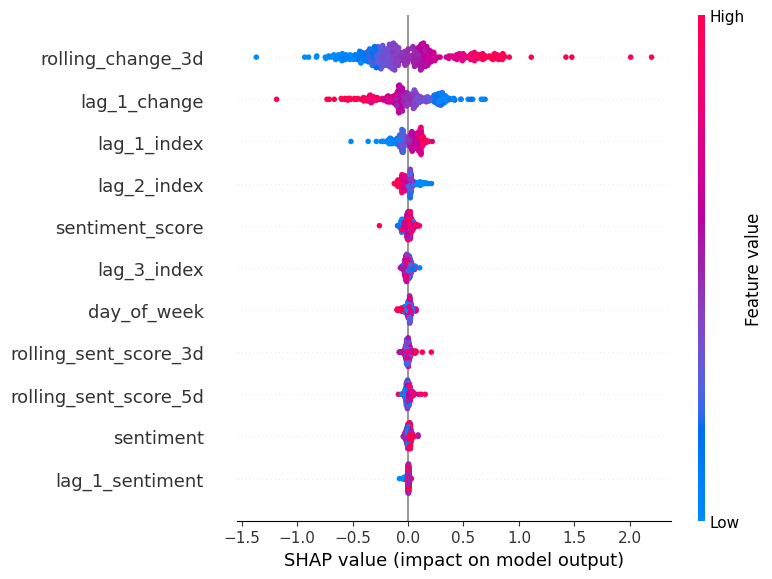

In [8]:
# Calculate SHAP values
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Plot detailed SHAP summary with value impacts
plt.figure(figsize=(10, 8)) 
shap.summary_plot(shap_values, X)